# Find brain tumors

Solution author: Asandei Stefan-Alexandru

In [557]:
import os
import copy
from typing import Tuple
import warnings

import numpy as np
import pandas as pd
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR
from torchvision.transforms import v2 as T
from torchvision.models import resnet18, ResNet18_Weights

In [558]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

batch_size = 16

root_path = "/home/stefan/ioai-prep/kits/aicc/round-0/brain-tumor"
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

warnings.filterwarnings("ignore")

# 1. Data processing

In [559]:
class BrainTumorDataset(Dataset):
    def __init__(self, is_train: bool):
        super().__init__()

        self.is_train = is_train
        self.ds_path = f"{root_path}/{'train' if is_train else 'test'}"

        self.paths = os.listdir(self.ds_path)

        self.transforms = T.Compose([
            T.Resize((224, 224)),
            T.PILToTensor(),
            T.ToDtype(torch.float32, scale=True),
        ]) if not is_train else T.Compose([
            T.Resize((224, 224)),
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomResizedCrop(224, scale=(0.8, 1.0)),
            T.ColorJitter(0.2, 0.2, 0.2, 0.1),
            T.PILToTensor(),
            T.ToDtype(torch.float32, scale=True),
        ])

    def __getitem__(self, idx):
        # format: ./dataset/test/0040.jpg
        img_path = f"{self.ds_path}/{self.paths[idx]}"
        img = Image.open(img_path).convert("RGB")

        if not self.is_train:
            return self.transforms(img)
        return self.transforms(img), self.transforms(img)

    def __len__(self):
        return len(self.paths)

In [560]:
train_ds = BrainTumorDataset(is_train=True)
test_ds = BrainTumorDataset(is_train=False)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [561]:
# sanity check
x = next(iter(test_loader))
x.shape

torch.Size([16, 3, 224, 224])

# 2. Model

In [562]:
class EMA:
    """Exponential moving-average update."""
    def __init__(self, online: nn.Module, target: nn.Module, tau: float = 0.996):
        self.online, self.target = online, target
        self.tau = tau
        for p in self.target.parameters():
            p.requires_grad = False
        self.update(0.0)

    def update(self, base_factor: float = 1.0):
        with torch.no_grad():
            for op, tp in zip(self.online.parameters(), self.target.parameters()):
                tp.data.lerp_(op.data, 1 - self.tau * base_factor)

In [563]:
class BYOL(nn.Module):
    """Minimal BYOL implementation."""
    def __init__(self, backbone: nn.Module, proj_dim: int = 256, pred_dim: int = 4096):
        super().__init__()
        self.backbone = backbone
        self.projector = nn.Sequential(
            nn.Linear(512, pred_dim), nn.BatchNorm1d(pred_dim), nn.ReLU(),
            nn.Linear(pred_dim, proj_dim)
        )
        self.predictor = nn.Sequential(
            nn.Linear(proj_dim, pred_dim), nn.BatchNorm1d(pred_dim), nn.ReLU(),
            nn.Linear(pred_dim, proj_dim)
        )

        self.target_backbone = copy.deepcopy(backbone)
        self.target_projector = copy.deepcopy(self.projector)

        self.ema = EMA(self.backbone, self.target_backbone)
        self.ema_proj = EMA(self.projector, self.target_projector)

    def forward(self, x1: torch.Tensor, x2: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # online branch
        z1 = self.projector(self.backbone(x1))
        p1 = self.predictor(z1)
        z2 = self.projector(self.backbone(x2))
        p2 = self.predictor(z2)

        # target branch (no grad)
        with torch.no_grad():
            t1 = self.target_projector(self.target_backbone(x1))
            t2 = self.target_projector(self.target_backbone(x2))

        return p1, p2, t1.detach(), t2.detach()

    def update_ema(self):
        self.ema.update()
        self.ema_proj.update()

In [564]:
backbone = resnet18(weights=ResNet18_Weights.DEFAULT)
backbone.fc = nn.Identity()
model = BYOL(backbone).to(device)

# sanity check
x1, x2 = next(iter(train_loader))
x1, x2 = x1.to(device), x2.to(device)
y = model(x1, x2)
[f.shape for f in y]

[torch.Size([16, 256]),
 torch.Size([16, 256]),
 torch.Size([16, 256]),
 torch.Size([16, 256])]

# 3. SSL Pretraining

In [565]:
def byol_loss(p1, p2, t1, t2):
    """Symmetric cosine-similarity loss."""
    def sim(x, y): return -nn.functional.cosine_similarity(x, y, dim=-1).mean()
    return (sim(p1, t2) + sim(p2, t1)) / 2

In [566]:
epochs = 20
milestone = 5
lr = 2e-4

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

warmup = LinearLR(optimizer, start_factor=0.1, total_iters=milestone)
cosine = CosineAnnealingLR(optimizer, T_max=epochs-milestone)
sched = SequentialLR(optimizer, schedulers=[warmup, cosine], milestones=[milestone])

scaler = torch.amp.GradScaler(device)

In [567]:
model.train()
losses = []

for epoch in range(epochs):
    running_loss = 0

    for x1, x2 in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        x1 = x1.to(device, memory_format=torch.channels_last)
        x2 = x2.to(device, memory_format=torch.channels_last)
        
        with torch.amp.autocast(device):
            p1, p2, t1, t2 = model(x1, x2)
            loss = byol_loss(p1, p2, t1, t2)

        model.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        model.update_ema()
        running_loss += loss.item()
        losses.append(loss.item())
    sched.step()
    print(f"Epoch {epoch+1} | cosine distance: {running_loss / len(train_loader):.4f}")

Epoch 1/20: 100%|██████████| 125/125 [00:25<00:00,  4.83it/s]


Epoch 1 | cosine distance: -0.5529


Epoch 2/20: 100%|██████████| 125/125 [00:26<00:00,  4.70it/s]


Epoch 2 | cosine distance: -0.7227


Epoch 3/20: 100%|██████████| 125/125 [00:26<00:00,  4.72it/s]


Epoch 3 | cosine distance: -0.8111


Epoch 4/20: 100%|██████████| 125/125 [00:25<00:00,  4.93it/s]


Epoch 4 | cosine distance: -0.8698


Epoch 5/20: 100%|██████████| 125/125 [00:26<00:00,  4.71it/s]


Epoch 5 | cosine distance: -0.9080


Epoch 6/20: 100%|██████████| 125/125 [00:25<00:00,  4.86it/s]


Epoch 6 | cosine distance: -0.9303


Epoch 7/20: 100%|██████████| 125/125 [00:25<00:00,  4.87it/s]


Epoch 7 | cosine distance: -0.9451


Epoch 8/20: 100%|██████████| 125/125 [00:25<00:00,  4.83it/s]


Epoch 8 | cosine distance: -0.9549


Epoch 9/20: 100%|██████████| 125/125 [00:26<00:00,  4.79it/s]


Epoch 9 | cosine distance: -0.9617


Epoch 10/20: 100%|██████████| 125/125 [00:26<00:00,  4.72it/s]


Epoch 10 | cosine distance: -0.9648


Epoch 11/20: 100%|██████████| 125/125 [00:25<00:00,  4.87it/s]


Epoch 11 | cosine distance: -0.9679


Epoch 12/20: 100%|██████████| 125/125 [00:25<00:00,  4.88it/s]


Epoch 12 | cosine distance: -0.9703


Epoch 13/20: 100%|██████████| 125/125 [00:26<00:00,  4.67it/s]


Epoch 13 | cosine distance: -0.9721


Epoch 14/20: 100%|██████████| 125/125 [00:26<00:00,  4.68it/s]


Epoch 14 | cosine distance: -0.9734


Epoch 15/20: 100%|██████████| 125/125 [00:26<00:00,  4.78it/s]


Epoch 15 | cosine distance: -0.9747


Epoch 16/20: 100%|██████████| 125/125 [00:26<00:00,  4.75it/s]


Epoch 16 | cosine distance: -0.9750


Epoch 17/20: 100%|██████████| 125/125 [00:26<00:00,  4.74it/s]


Epoch 17 | cosine distance: -0.9751


Epoch 18/20: 100%|██████████| 125/125 [00:26<00:00,  4.68it/s]


Epoch 18 | cosine distance: -0.9757


Epoch 19/20: 100%|██████████| 125/125 [00:26<00:00,  4.72it/s]


Epoch 19 | cosine distance: -0.9757


Epoch 20/20: 100%|██████████| 125/125 [00:25<00:00,  4.91it/s]

Epoch 20 | cosine distance: -0.9748


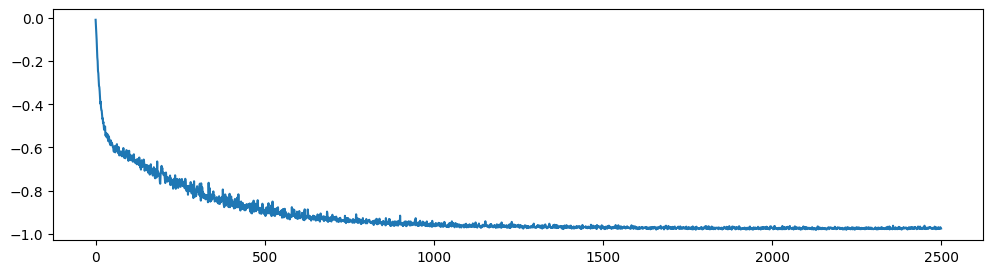

In [568]:
plt.figure(figsize=(12, 3))
plt.plot(losses)

In [569]:
torch.save(model.state_dict(), "byol.pth")

# 4. Classification fine-tuning

In [610]:
model.load_state_dict(torch.load("byol.pth"))

classifier = nn.Sequential(
    model.backbone,
    nn.Linear(512, 4)
).to(device)

for p in classifier.parameters():
    p.requires_grad = True

In [611]:
class LabeledDataset(Dataset):
    def __init__(self):
        super().__init__()

        self.label_encoder = LabelEncoder()

        self.df = pd.read_csv(f"{root_path}/train.csv")
        self.df["image_id"] = self.df["image_id"].map(lambda x: f"{x:04d}")
        self.df["label"] = self.label_encoder.fit_transform(self.df["label"])

        self.ids = self.df["image_id"].values
        self.paths = [f"{root_path}/train/{i}.jpg" for i in self.ids]

        self.transforms = T.Compose([
            T.Resize((224, 224)),
            T.PILToTensor(),
            T.RandomHorizontalFlip(),
            T.ColorJitter(0.4, 0.4, 0.4, 0.1),
            T.ToDtype(torch.float32, scale=True),
        ])

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img = Image.open(img_path).convert("RGB")
        label = torch.tensor(self.df["label"].values[idx])
        return self.transforms(img), label
    
    def __len__(self):
        return len(self.ids)

In [612]:
labeled_ds = LabeledDataset()
labeled_loader = DataLoader(labeled_ds, batch_size, shuffle=True)

batch = next(iter(labeled_loader))
[b.shape for b in batch]

[torch.Size([16, 3, 224, 224]), torch.Size([16])]

In [613]:
epochs = 7

optimizer = torch.optim.AdamW(classifier.parameters(), lr=2e-4)
ce_loss = nn.CrossEntropyLoss()

classifier.train()
losses = []

for epoch in range(epochs):
    running_loss = 0

    for x, y in tqdm(labeled_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        x = x.to(device, memory_format=torch.channels_last)
        y = y.to(device)
        
        with torch.amp.autocast(device):
            y_pred = classifier(x)
            loss = ce_loss(y_pred, y)

        classifier.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(classifier.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        losses.append(loss.item())
    print(f"Epoch {epoch+1} | loss: {running_loss / len(labeled_loader):.4f}")

Epoch 1/7: 100%|██████████| 3/3 [00:00<00:00,  7.80it/s]


Epoch 1 | loss: 1.1356


Epoch 2/7: 100%|██████████| 3/3 [00:00<00:00,  8.10it/s]


Epoch 2 | loss: 0.3090


Epoch 3/7: 100%|██████████| 3/3 [00:00<00:00,  7.82it/s]


Epoch 3 | loss: 0.1020


Epoch 4/7: 100%|██████████| 3/3 [00:00<00:00,  7.66it/s]


Epoch 4 | loss: 0.0245


Epoch 5/7: 100%|██████████| 3/3 [00:00<00:00,  7.74it/s]


Epoch 5 | loss: 0.0186


Epoch 6/7: 100%|██████████| 3/3 [00:00<00:00,  8.24it/s]


Epoch 6 | loss: 0.0047


Epoch 7/7: 100%|██████████| 3/3 [00:00<00:00,  8.08it/s]

Epoch 7 | loss: 0.0027


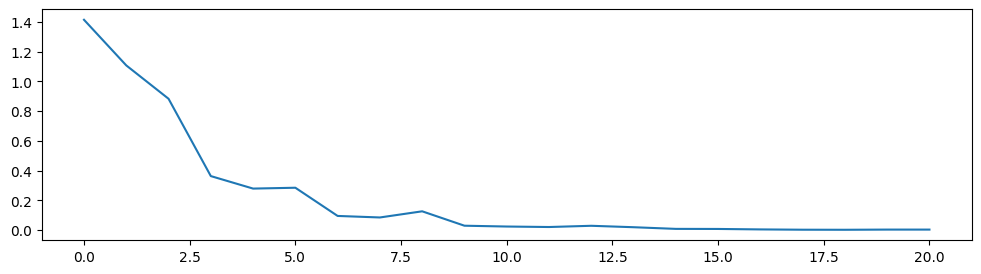

In [614]:
plt.figure(figsize=(12, 3))
plt.plot(losses)

In [615]:
torch.save(classifier.state_dict(), "pretrained_byol.pth")

# 5. Pseudo-labeling finetune

In [616]:
classifier.load_state_dict(torch.load("pretrained_byol.pth"))

<All keys matched successfully>

In [617]:
class LabeledDataset(Dataset):
    def __init__(self, df: pd.DataFrame, root_path: str, label_encoder: LabelEncoder):
        self.df = df.reset_index(drop=True)
        self.paths = [f"{root_path}/train/{x:04d}.jpg" for x in self.df["image_id"]]
        self.labels = label_encoder.transform(self.df["label"])
        self.transforms = T.Compose([
            T.Resize((224, 224)),
            T.RandomHorizontalFlip(),
            T.ColorJitter(0.2, 0.2, 0.2, 0.1),
            T.PILToTensor(),
            T.ToDtype(torch.float32, scale=True),
        ])

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return self.transforms(img), torch.tensor(self.labels[idx])

    def __len__(self):
        return len(self.paths)


class UnlabeledDataset(Dataset):
    def __init__(self, df: pd.DataFrame, root_path: str):
        self.df = df.reset_index(drop=True)
        self.paths = [f"{root_path}/train/{x:04d}.jpg" for x in self.df["image_id"]]
        self.transforms = T.Compose([
            T.Resize((224, 224)),
            T.RandomHorizontalFlip(),
            T.ColorJitter(0.2, 0.2, 0.2, 0.1),
            T.PILToTensor(),
            T.ToDtype(torch.float32, scale=True),
        ])

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return self.transforms(img), -1  # dummy label

    def __len__(self):
        return len(self.paths)

In [618]:
# Split train.csv into labeled (2%) and unlabeled sets
df = pd.read_csv(f"{root_path}/train.csv")
df["image_id"] = df["image_id"].map(lambda x: int(x))  # ensure int IDs

label_encoder = LabelEncoder()
label_encoder.fit(df["label"])

labeled_idx = df.sample(frac=0.02, random_state=seed).index
unlabeled_idx = df.drop(labeled_idx).index

df_labeled = df.loc[labeled_idx].reset_index(drop=True)
df_unlabeled = df.loc[unlabeled_idx].reset_index(drop=True)

print(f"Labeled: {len(df_labeled)} | Unlabeled: {len(df_unlabeled)}")

labeled_ds = LabeledDataset(df_labeled, root_path, label_encoder)
unlabeled_ds = UnlabeledDataset(df_unlabeled, root_path)

labeled_loader = DataLoader(labeled_ds, batch_size, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_ds, batch_size, shuffle=True)

Labeled: 1 | Unlabeled: 47


In [619]:
teacher = copy.deepcopy(classifier).eval().to(device)
for p in teacher.parameters():
    p.requires_grad = False

student = classifier  # direct reference
student.train()

ema_decay = 0.99
conf_threshold = 0.8
lambda_u_max = 1.0
epochs = 10

optimizer = torch.optim.AdamW(student.parameters(), lr=3e-4)
ce_loss = nn.CrossEntropyLoss()

In [620]:
for epoch in range(epochs):
    running_loss = 0.0

    # zip so both sets align; cycle unlabeled if shorter
    unlabeled_iter = iter(unlabeled_loader)

    for x_l, y_l in tqdm(labeled_loader, desc=f"Pseudo epoch {epoch+1}/{epochs}"):
        # get unlabeled batch (restart if needed)
        try:
            x_u, _ = next(unlabeled_iter)
        except StopIteration:
            unlabeled_iter = iter(unlabeled_loader)
            x_u, _ = next(unlabeled_iter)

        x_l, y_l = x_l.to(device, memory_format=torch.channels_last), y_l.to(device)
        x_u = x_u.to(device, memory_format=torch.channels_last)

        # --- supervised loss
        with torch.amp.autocast(device):
            logits_l = student(x_l)
            loss_sup = ce_loss(logits_l, y_l)

        # --- teacher generates pseudo labels
        with torch.no_grad():
            t_probs = torch.softmax(teacher(x_u), dim=1)
            conf, pseudo = t_probs.max(1)
            mask = conf > conf_threshold

        if mask.sum() > 0:
            with torch.amp.autocast(device):
                logits_u = student(x_u[mask])
                loss_unsup = ce_loss(logits_u, pseudo[mask])
        else:
            loss_unsup = 0.0

        # --- combine losses
        weight = min(1.0, epoch / 5) * lambda_u_max
        loss = loss_sup + weight * loss_unsup

        # --- update student
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # --- update teacher (EMA)
        with torch.no_grad():
            for t, s in zip(teacher.parameters(), student.parameters()):
                t.data.mul_(ema_decay).add_(s.data, alpha=1 - ema_decay)

        running_loss += loss.item()

    avg_loss = running_loss / len(labeled_loader)
    print(f"Epoch {epoch+1} | combined loss: {avg_loss:.4f}")

Pseudo epoch 1/10: 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


Epoch 1 | combined loss: 1.4717


Pseudo epoch 2/10: 100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


Epoch 2 | combined loss: 1.0999


Pseudo epoch 3/10: 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]


Epoch 3 | combined loss: 0.6801


Pseudo epoch 4/10: 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


Epoch 4 | combined loss: 0.5530


Pseudo epoch 5/10: 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


Epoch 5 | combined loss: 0.3298


Pseudo epoch 6/10: 100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


Epoch 6 | combined loss: 0.2419


Pseudo epoch 7/10: 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


Epoch 7 | combined loss: 0.1664


Pseudo epoch 8/10: 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


Epoch 8 | combined loss: 0.1170


Pseudo epoch 9/10: 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


Epoch 9 | combined loss: 0.3248


Pseudo epoch 10/10: 100%|██████████| 1/1 [00:00<00:00,  8.14it/s]

Epoch 10 | combined loss: 0.0604


# 6. Embeddings visualization

In [621]:
resnet = classifier[0].eval().to(device)
for p in resnet.parameters():
    p.requires_grad = False

In [622]:
def tta_predict(model, img, n_aug=3, device=device):
    """simple TTA: average logits over n_aug random transforms"""
    model.eval()
    tf = T.Compose([
        T.Resize((224, 224)),

        T.RandomHorizontalFlip(p=0.5),
        T.RandomVerticalFlip(p=0.5),

        T.PILToTensor(),
        T.ToDtype(torch.float32, scale=True),
    ])
    with torch.no_grad():
        logits = torch.stack([model(tf(img).unsqueeze(0).to(device)) for _ in range(n_aug)]).mean(0)
    return logits

In [623]:
preds, test_images = [], []

with torch.no_grad():
    for img_batch in tqdm(test_loader):
        img_batch = img_batch.to(device)
        out = classifier(img_batch)
        embeddings = resnet(img_batch)
        test_images.append(embeddings)

    # TTA on single images
    for img_path in tqdm(test_ds.paths):
        img = Image.open(f"{root_path}/test/{img_path}").convert("RGB")
        preds_tta = tta_predict(classifier, img).argmax(1).item()
        preds.append(preds_tta)
        
test_images = torch.cat(test_images, dim=0)

100%|██████████| 1311/1311 [00:16<00:00, 78.80it/s]


In [624]:
tsne = TSNE(n_components=2)

y_2d = tsne.fit_transform(test_images.detach().cpu())

In [625]:
km = KMeans(n_clusters=4, random_state=seed)

clusters = km.fit_predict(test_images.detach().cpu())

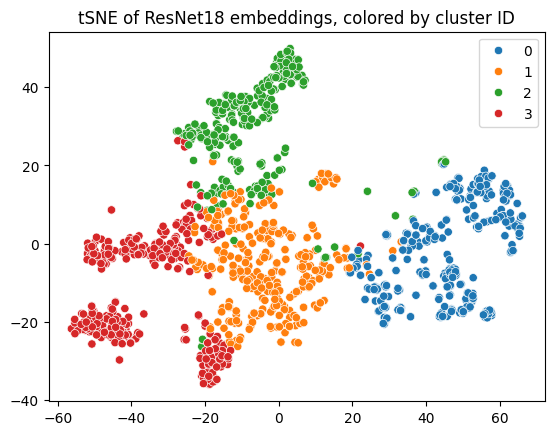

In [626]:
sns.scatterplot(
    x=y_2d[:, 0], y=y_2d[:, 1],
    hue=clusters,
    palette="tab10",
    legend="full"
)
plt.title("tSNE of ResNet18 embeddings, colored by cluster ID")
plt.show()

# 7. Submission

In [627]:
preds = [label_encoder.inverse_transform(np.array([c]))[0] for c in preds]	
ids = [p[:len(".jpg")] for p in test_ds.paths]

In [628]:
sub = pd.DataFrame({"ID": ids, "prediction": preds})
sub.head()

,ID,prediction
0,0040,notumor
1,0503,meningioma
2,1029,pituitary
3,0065,pituitary
4,0437,notumor


In [629]:
sub.to_csv("submission.csv", index=False)